## 训练分类器

* 使用CIFAR10数据集

* 它具有以下类别：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”。CIFAR-10中的图像尺寸为3x32x32，即尺寸为32x32像素的3通道彩色图像。

## 1、加载并标准化CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

* torchvision数据集的输出是[0，1]范围的PILImage图像，需要将它们转换为归一化范围[-1，1]的张量

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


* 展示一些训练图像，很有趣。

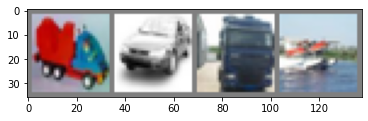

truck   car truck plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2、定义卷积神经网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3、定义损失函数和优化器

* 使用分类交叉熵损失和带有动量的SGD。

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4、训练网络

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.220
[1,  4000] loss: 1.843
[1,  6000] loss: 1.689
[1,  8000] loss: 1.591
[1, 10000] loss: 1.545
[1, 12000] loss: 1.485
[2,  2000] loss: 1.399
[2,  4000] loss: 1.364
[2,  6000] loss: 1.355
[2,  8000] loss: 1.318
[2, 10000] loss: 1.316
[2, 12000] loss: 1.270
Finished Training


In [7]:
# 保存数据
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5.在测试数据上测试网络

* 显示测试集中的图像以使其熟悉。

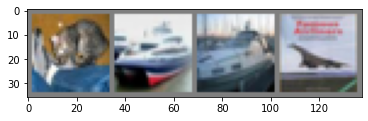

GroundTruth:    cat  ship  ship plane


In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
# 重新加载保存的模型
net = Net()
PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
# 现在让我们看看神经网络对以上这些示例的看法：
outputs = net(images)

In [10]:
# The outputs are energies for the 10 classes. 
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog  ship  ship  ship


In [11]:
# 网络在整个数据集上的表现。
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [12]:
# 嗯，哪些类的表现良好，哪些类的表现不佳：
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 39 %
Accuracy of   car : 55 %
Accuracy of  bird : 36 %
Accuracy of   cat : 34 %
Accuracy of  deer : 50 %
Accuracy of   dog : 31 %
Accuracy of  frog : 77 %
Accuracy of horse : 59 %
Accuracy of  ship : 90 %
Accuracy of truck : 57 %


# 在GPU上训练

* 如果我们有可用的CUDA，首先让我们将设备定义为第一个可见的cuda设备：

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
# 然后，这些方法将递归遍历所有模块，并将其参数和缓冲区转换为CUDA张量

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
# 训练
# 请记住，您还必须将每一步的input和target也发送到GPU：

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.202
[1,  4000] loss: 1.903
[1,  6000] loss: 1.707
[1,  8000] loss: 1.608
[1, 10000] loss: 1.534
[1, 12000] loss: 1.520
[2,  2000] loss: 1.424
[2,  4000] loss: 1.424
[2,  6000] loss: 1.381
[2,  8000] loss: 1.374
[2, 10000] loss: 1.338
[2, 12000] loss: 1.355
Finished Training
